# The needed Libraries

In [1]:
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import matplotlib.pylab as plt
from sklearn.preprocessing import LabelEncoder
import cv2
from PIL import Image
import numpy as np
import seaborn as sns
from collections import Counter
import os
import warnings
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models

warnings.filterwarnings('ignore')

# Utilites

In [2]:
def parse_annotations(file_path):
    """
    Parses an annotations file to extract labels and bounding boxes.

    Args:
        file_path (str): Path to the annotations file.

    Returns:
        Dict[str, Dict]: A dictionary with image file names as keys and label/box data as values.
    """
    annotations = {}

    try:
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                img_file = parts[0]
                label = parts[1]
                boxes = []
                for i in range(2, len(parts), 5):
                    x, y, w, h, action = int(parts[i]), int(parts[i + 1]), int(parts[i + 2]), int(parts[i + 3]), parts[
                        i + 4]
                    boxes.append({'bbox': (x, y, w, h), 'action': action})
                annotations[img_file] = {'labels': label, 'boxes': boxes}
    except Exception as e:
        print(f'Error reading annotations file {file_path}. Details {e}')
    return annotations


def visualize_image(image_path, annotations):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    for box in annotations['boxes']:
        x, y, w, h = box['bbox']
        action = box['action']

        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        plt.text(x, y - 10, action, color='red', fontsize=12, backgroundcolor='white')
    plt.title(f"Label: {annotations['labels']}")
    plt.axis('off')
    plt.show()


def visualize_head(data_folder, number_images=1):
    annotations = parse_annotations(os.path.join(data_folder, 'annotations.txt'))
    for i, img_file in enumerate(list(annotations.keys())[0:number_images]):
        img_name = os.path.splitext(img_file)[0]
        image_path = os.path.join(data_folder, img_name, img_file)
        visualize_image(image_path, annotations[img_file])


def get_data_and_labels(root_folder):
    """
    Reads images and labels from the specified data folder, including the five images before
    and the four images after the target image.

    Args:
        root_folder (str): Path to the root data directory.

    Returns:
        Tuple[List[Image.Image], List[str], List[Tuple[int, int]], List[str], List[List[Dict]]]:
        A list of images, their corresponding labels, sizes, formats, and bounding boxes.
    """
    data = []
    labels = []
    image_sizes = []
    image_formats = []
    boxes = []

    folders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]

    for folder in folders:
        annotation_file = os.path.join(root_folder, folder, 'annotations.txt')
        if not os.path.exists(annotation_file):
            print(f'Warning: Missing annotation file in folder {folder}')
            continue

        annotations = parse_annotations(annotation_file)
        for image_name, annotation in annotations.items():
            try:
                base_name = os.path.splitext(image_name)[0]
                image_index = int(base_name)

                for img_idx in range(image_index - 5, image_index + 5):
                    img_file = f"{img_idx}.jpg"
                    image_path = os.path.join(root_folder, folder, base_name,img_file)

                    if not os.path.exists(image_path):
                        print(f"Warning: Missing image file {image_path}")
                        continue

                    img = Image.open(image_path)
                    data.append(img)
                    labels.append(annotation['labels'])
                    image_sizes.append(img.size)  # Add image size (width, height)
                    image_formats.append(img.format)  # Add image format (JPEG, PNG, etc.)
                    boxes.append(annotation['boxes'])
            except ValueError:
                print(f"Skipping non-numeric image name: {image_name}")
            except Exception as e:
                print(f"Error loading image {image_name}. Details: {e}")

    return data, labels, image_sizes, image_formats, boxes


def show_random_samples(data, labels, num_samples=5):
    indices = np.random.choice(len(data), num_samples, replace=False)
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(data[idx])
        plt.title(f'Label: {labels[idx]}')
        plt.axis('off')
    plt.show()


# Fetch the data

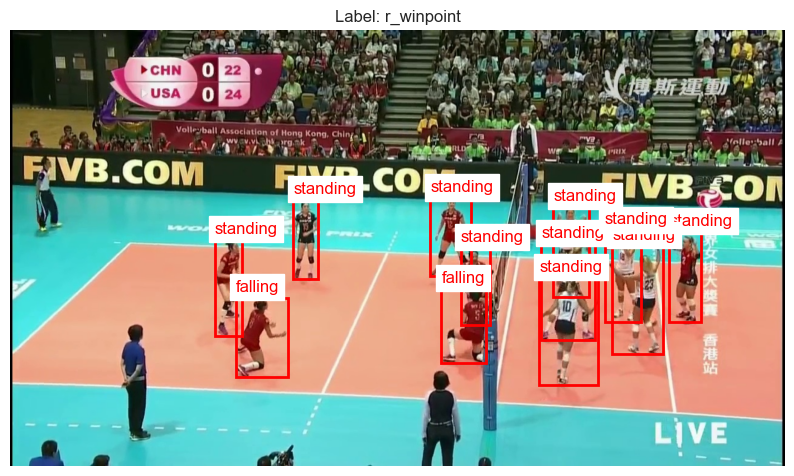

In [4]:
data_folder = '/Users/bdallhsydbdallh/PycharmProjects/Volleyball_deep_learning_project/Data'
data, labels, image_sizes, image_formats, boxes = get_data_and_labels(data_folder)

visualize_head('/Users/bdallhsydbdallh/PycharmProjects/Volleyball_deep_learning_project/Data/0')

# Explor Data Analysis

In [ ]:
print(f'Total number of Iamges: {len(data)}')
print(f'Total number of labels: {len(labels)}')

# Visualize label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xlabel('Activity Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
show_random_samples(data, labels)

In [ ]:
image_widths = [size[0] for size in image_sizes]
image_heights = [size[1] for size in image_sizes]

print(f'Image Width - Mean: {np.mean(image_widths)}, Std: {np.std(image_widths)}')
print(f'Image Heights - Mean: {np.mean(image_heights)}, Std: {np.std(image_heights)}')

plt.figure(figsize=(10, 5))
plt.hist(image_widths, bins=20, alpha=.7, label='Width')
plt.hist(image_heights, bins=20, alpha=.7, label='Heigh')
plt.legend(loc='upper right')
plt.title('Image Dimensions (Width & Height)')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.show()

format_counts = Counter(image_formats)
print(f'Image Formats: {format_counts}')

### Augmentations

In [ ]:
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(244, scale=(.8, 1)),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
])
augemnted_image = transform_aug(data[0])
plt.imshow(augemnted_image.permute(1, 2, 0))  # convert tensor to image format
plt.title('Augmented Image')
plt.axis('off')
plt.show()

In [ ]:
def plot_with_box(image, boxes):
    image = np.array(image)  # Convert PIL image to NumPy array for plotting
    plt.imshow(image)
    for bbox in boxes:
        x, y, w, h = bbox['bbox']
        plt.gca().add_patch(
            plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        )


plot_with_box(data[0], boxes[0])
plt.axis('off')
plt.show()

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(data, labels, test_size=.1, random_state=42, shuffle=True)
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=.2, random_state=42, shuffle=True)

xtrain_tensor = torch.stack([transform_aug(img) for img in xtrain])
xval_tensor = torch.stack([transform_aug(img) for img in xval])
xtest_tensor = torch.stack([transform_aug(img) for img in xtest])

# Encode labels
le = LabelEncoder()
ytrain_encoded = le.fit_transform(ytrain)
yval_encoded = le.transform(yval)
ytest_encoded = le.transform(ytest)
# Convert to tensors
ytrain_tensor = torch.tensor(ytrain_encoded)
yval_tensor = torch.tensor(yval_encoded)
ytest_tensor = torch.tensor(ytest_encoded)

# Create TensorDataset instances
train = TensorDataset(xtrain_tensor, ytrain_tensor)
val = TensorDataset(xval_tensor, yval_tensor)
test = TensorDataset(xtest_tensor, ytest_tensor)

# Implement Baseline-1

In [ ]:
# Load and modify the ResNet50 model
resnet50 = models.resnet50(pretrained=True)
resnet_n_in_fc = resnet50.fc.in_features
resnet50.fc = nn.Linear(resnet_n_in_fc, 8)

# Freeze all layers except the final fully connected layer
for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True

train_loader = DataLoader(train, batch_size=32, shuffle=True)
valid_loader = DataLoader(val, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

# Optimizer and loss function
optimizer = torch.optim.Adam(resnet50.parameters(), lr=.001)
loss_fn = nn.CrossEntropyLoss()

# Device setup
device = 'mps' if torch.mps.is_available() else 'cpu'
resnet50.to(device);

### Training phase

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, label in train_loader:
        inputs, label = inputs.to(device), label.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(inputs)
        loss = loss_fn(outputs, label)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    # Calculate training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validation phase
    resnet50.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, label in valid_loader:
            inputs, label = inputs.to(device), label.to(device)
            outputs = resnet50(inputs)
            loss = loss_fn(outputs, label)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += label.size(0)
            val_correct += (predicted == label).sum().item()

    val_loss = val_loss / len(valid_loader)
    val_acc = val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

### Evaluate on the test set

In [ ]:
resnet50.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, label in test_loader:
        inputs, label = inputs.to(device), label.to(device)
        outputs = resnet50(inputs)
        loss = loss_fn(outputs, label)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += label.size(0)
        test_correct += (predicted == label).sum().item()

test_loss = test_loss / len(test_loader)
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

### Save the model

In [ ]:
torch.save(resnet50.state_dict(), 'fine_tuned_resnet50.pth')

# Implement Baseline-2

# Implement Baseline-3

# Implement Baseline-4

# Implement Baseline-5

# Implement Baseline-6

# Implement Baseline-7

# Implement Baseline-8
